In [12]:
import numpy as np
import pinocchio as pin
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
sys.path.append('/workspace/')
from pinocchio_template import Thneed
from collections import deque

In [24]:
t = Thneed(urdf_filename="/workspace/sqpcpu/urdfs/indy7.urdf", eepos_frame_name="end_effector", N=16, dt=0.01, max_qp_iters=4)
data = np.load('/workspace/sqpcpu/data/state_transitions_batchctrl_1_tmp2.npy') 
# data = np.load('/workspace/sqpcpu/data/state_transitions_batchctrl_2_tmp.npy')
data.shape

(2999, 32)

In [14]:
# null_fext = pin.StdVec_Force()
# for _ in range(t.model.njoints):
#     null_fext.append(pin.Force.Zero())
# q = data[0,:6]
# v = data[0,6:12]
# u = data[0,12:18]
# dt = data[0,18]
# qnext = data[0,19:25]
# vnext = data[0,25:31]
# stepend = data[0,31]
# t.predict_forward(q, v, u, dt, null_fext)

In [15]:
force_steps = [0, 1, -1, 1, 1, 0, -1, 0, 1, -1, 1, -1, 1, 0, 1, -1, 0, 1, -1, 0, -1, 0]
# force_steps = [0, 1, 0, -1, 0, 1, 0, -1, 1]
applied_forces_timesteps = np.linspace(0, data[-1,-1], len(data))
applied_forces = np.zeros(len(data))
for i in range(len(data)):
    applied_forces[i] = force_steps[int(applied_forces_timesteps[i] / 4)]

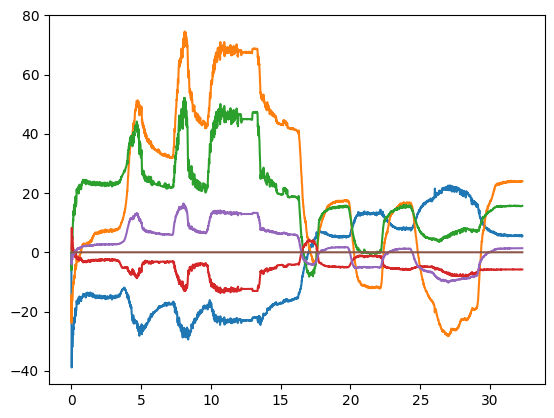

In [16]:
#transition = np.hstack([self.last_xs, torque_mean, self.xs, step_duration, self.msg_time - self.start_time])

times = data[:,31]
commands = data[:,12:18]
plt.plot(times, commands)
plt.show()



In [30]:
# forces = [-20.0, -15.0, -10.0, -5.0, -2.0, -1.0, -0.5, -0.4, -0.3, -0.2, -0.1, -0.01, 0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
forces = np.linspace(-300.0, 300.0, 50)

best_forces_timesteps = np.zeros((data.shape[0], 3))
forces_errors = np.zeros((data.shape[0], 1 + len(forces)))

base_fext = pin.StdVec_Force()
for _ in range(t.model.njoints):
    base_fext.append(pin.Force.Zero())
    

timesteps_to_predict = 5
for i in range(timesteps_to_predict, len(data)):
    stepend = data[i,31]
    best_force = None
    best_error = np.inf

    forces_errors[i,0] = stepend

    all_frc_errors = np.zeros(len(forces))

    for j, force in enumerate(forces):
        error = 0.0
        base_fext[5] = pin.Force(np.array([0,force,0]), np.array([0,0,0]))
        for ts in range(timesteps_to_predict):
            q = data[i-ts,:6]
            v = data[i-ts,6:12]
            u_mean = data[i-ts,12:18]
            qnext = data[i-ts,18:24]
            vnext = data[i-ts,24:30]
            dt = data[i-ts,30]

            qnext_pred, vnext_pred = t.predict_forward(q, v, u_mean, dt, base_fext)
            error += np.linalg.norm(vnext_pred - vnext)
            error += 1e-3 * np.sqrt(abs(force))

        forces_errors[i,j+1] = error
        all_frc_errors[j] = error

    best_frc = forces[np.argmin(all_frc_errors)]
    best_error = np.min(all_frc_errors)

    best_forces_timesteps[i,:] = [stepend, best_frc, best_error]

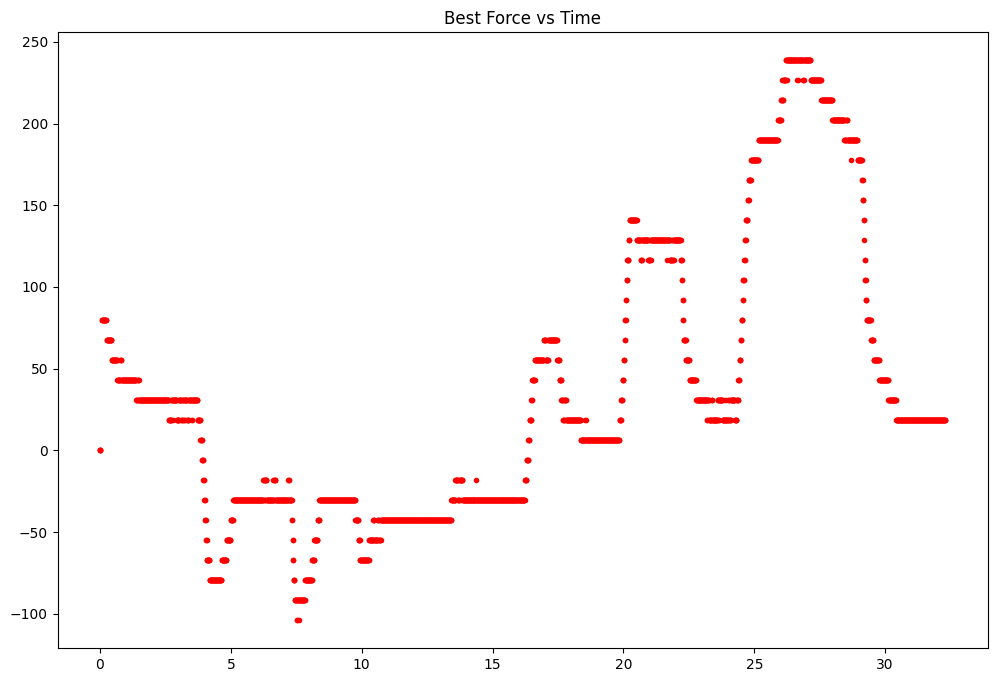

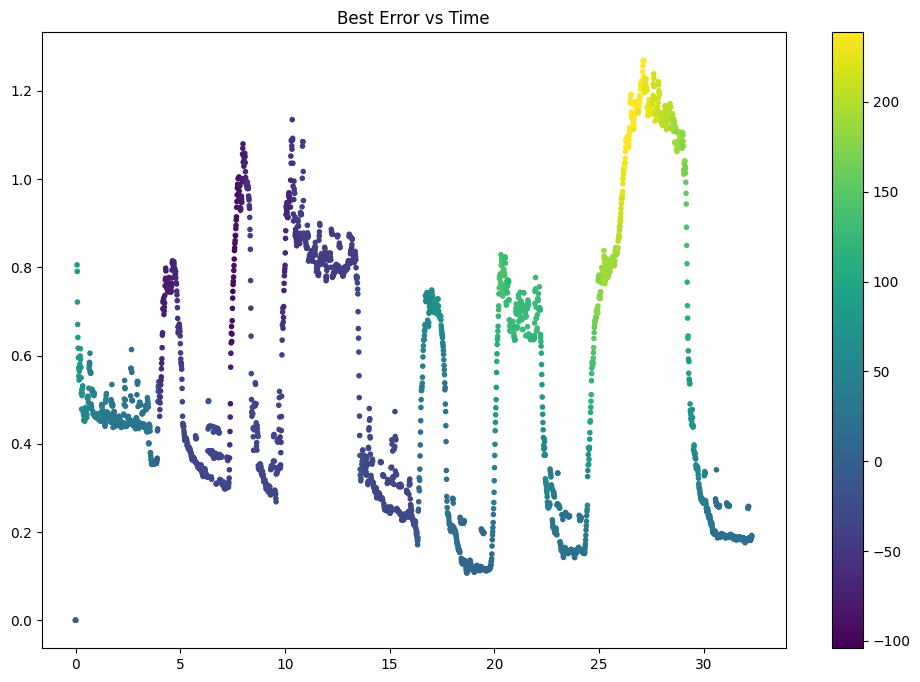

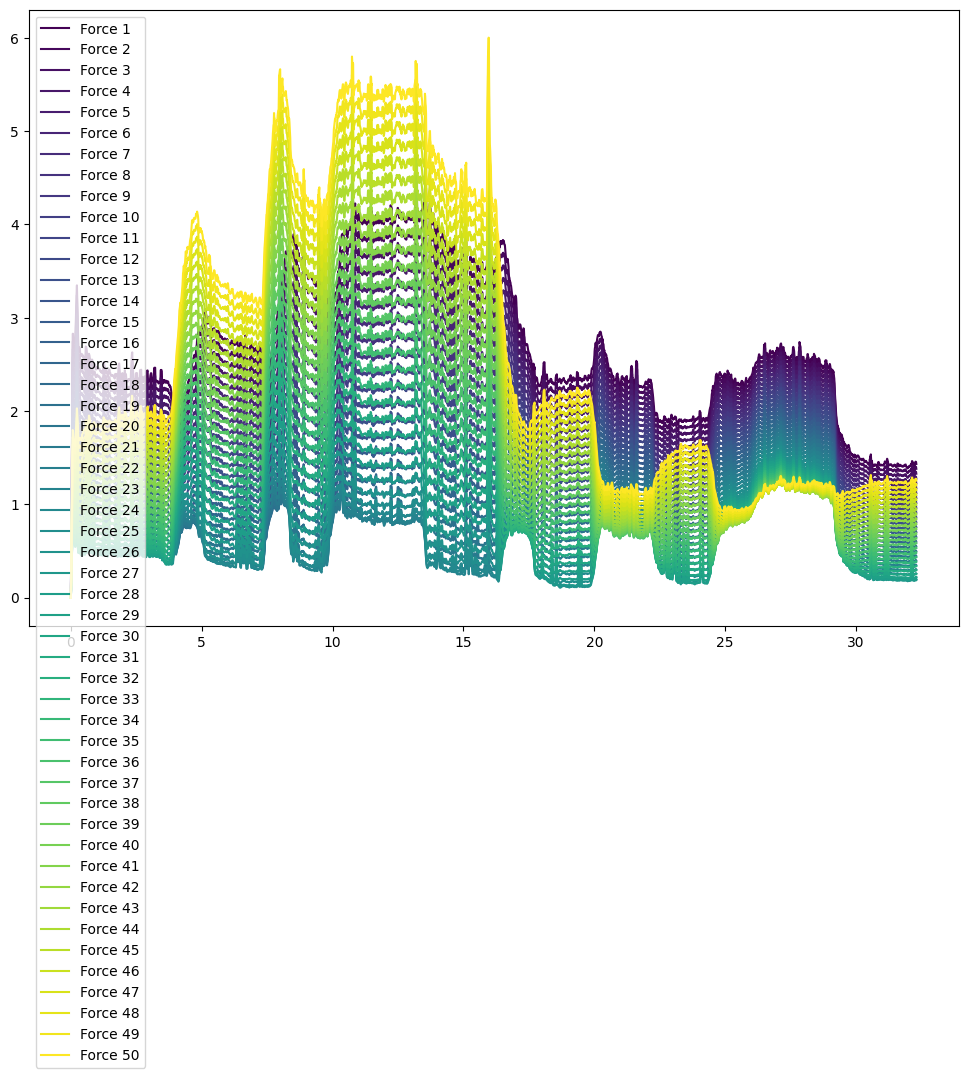

In [31]:
applied_force_mult = 10.0
plt.figure(figsize=(12, 8))
plt.scatter(best_forces_timesteps[:,0], best_forces_timesteps[:,1], color='red', marker='.')
# plt.plot(applied_forces_timesteps, 10 + applied_forces * applied_force_mult, color='blue')
# plt.ylim(-10, 80)
plt.title('Best Force vs Time')
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(best_forces_timesteps[:,0], best_forces_timesteps[:,2], marker='.', c=best_forces_timesteps[:,1], cmap='viridis')
plt.colorbar()
# plt.ylim(-0.2, 0.4)
# plt.plot(applied_forces_timesteps, applied_forces * 0.1, color='blue')
plt.title('Best Error vs Time')
plt.show()


plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('viridis')
num_lines = forces_errors.shape[1] - 1
for i in range(num_lines):
    color = cmap(i / (num_lines - 1))
    plt.plot(forces_errors[:,0], forces_errors[:,i+1], color=color, label=f'Force {i+1}')

plt.legend()
plt.show()



In [37]:
# algorithm test
frc_stddev = 5.0
frcs = np.array([0,0])
frc_deque = deque(maxlen=5)


best_forces_timesteps = np.zeros((data.shape[0], 3))
forces_errors = np.zeros((data.shape[0], 1 + len(frcs)))
frc_hist = np.zeros((data.shape[0], 2))

base_fext = pin.StdVec_Force()
for _ in range(t.model.njoints):
    base_fext.append(pin.Force.Zero())


timesteps_to_predict = 5
for i in range(timesteps_to_predict, len(data)):
    stepend = data[i,31]
    best_force = None
    best_error = np.inf

    forces_errors[i,0] = stepend

    all_frc_errors = np.zeros(len(frcs))

    for j, force in enumerate(frcs):
        error = 0.0
        base_fext[5] = pin.Force(np.array([0,force,0]), np.array([0,0,0]))
        for ts in range(timesteps_to_predict):
            q = data[i-ts,:6]
            v = data[i-ts,6:12]
            u_mean = data[i-ts,12:18]
            qnext = data[i-ts,18:24]
            vnext = data[i-ts,24:30]
            dt = data[i-ts,30]

            qnext_pred, vnext_pred = t.predict_forward(q, v, u_mean, dt, base_fext)
            error += np.linalg.norm(vnext_pred - vnext)
            # error += 1e-3 * np.sqrt(abs(force))

        forces_errors[i,j+1] = error
        all_frc_errors[j] = error

    frc_deque.append(frcs[np.argmin(all_frc_errors)])
    best_frc = np.mean(frc_deque)
    best_error = np.min(all_frc_errors)
    best_forces_timesteps[i,:] = [stepend, best_frc, best_error]

    frc_hist[i,:] = frcs

    frcs = np.array([best_frc - frc_stddev, best_frc + frc_stddev])

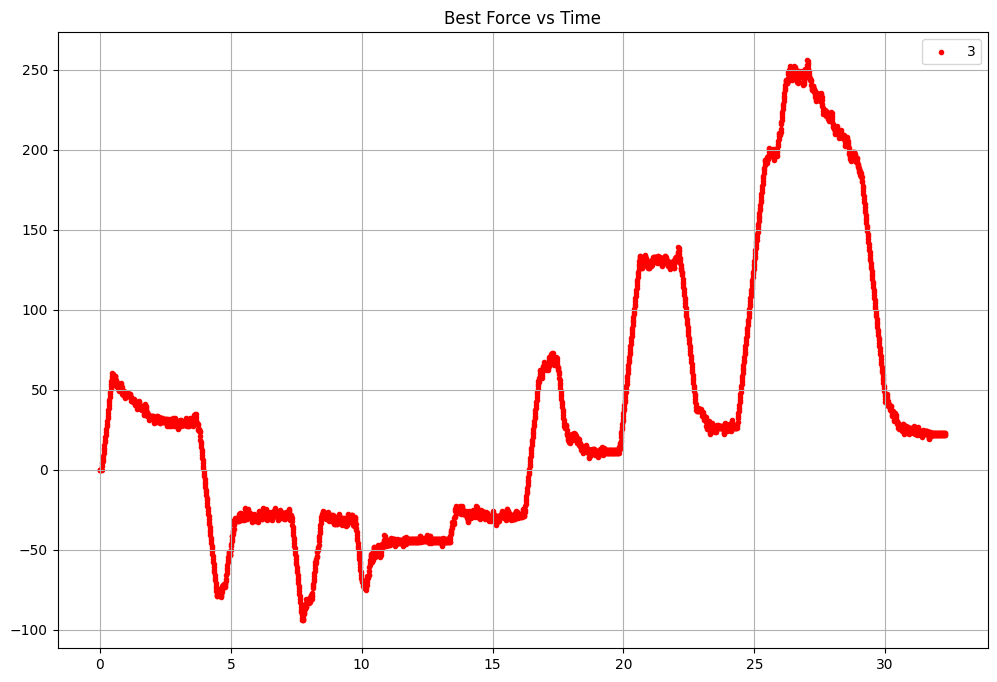

In [38]:
plt.figure(figsize=(12, 8))
plt.scatter(best_forces_timesteps[:,0], best_forces_timesteps[:,1], color='red', marker='.')
# plt.plot(best_forces_timesteps[:,0], frc_hist[:,0], color='blue')
# plt.plot(best_forces_timesteps[:,0], frc_hist[:,1], color='green')

plt.legend(['3', '2'])
plt.grid()
plt.title('Best Force vs Time')
plt.show()